In [1]:
%matplotlib inline
from gurobipy import *
import xlrd
from numpy import *
from matplotlib import pyplot as plt

In [2]:
# there are 71 papers and 21 referees

noPapers = 71
noReferees = 21

In [3]:
# read data from xlsx

workbook = xlrd.open_workbook('paper_preferences.xlsx')
worksheet = workbook.sheet_by_index(2)
preferences = [[0 for _ in range(noReferees)] for __ in range(noPapers)]

for i in range(1, noPapers+1):
    for j in range(1, noReferees+1):
        preferences[i-1][j-1] = worksheet.cell_value(i,j)

In [4]:
map = { 'yes':0, 'maybe':1, 'no':2, 'conflict':3 }
for i in range(noPapers):
    for j in range(noReferees):
        preferences[i][j] = map[preferences[i][j]]

In [5]:
# create a model
model = Model('assignment')

# create decision variables and store them in the array assignments
assignments = [[0 for _ in range(noReferees)] for __ in range(noPapers)]
for i in range(noPapers):
    for j in range(noReferees):
        curVar = model.addVar( vtype = GRB.BINARY, \
                               name = "x" + "("+ str(i) + "," + str(j) + ")")
        assignments[i][j] = curVar
model.update()

In [6]:
# create linear expression for the objective

objExpr = LinExpr()
for i in range(noPapers):
    for j in range(noReferees):
        curVar = assignments[i][j]
        objExpr += preferences[i][j] * curVar
model.setObjective( objExpr, GRB.MINIMIZE )
model.update()

In [7]:
# constraits
# constrait 1 : each paper gets reviewed by 3 referees
# sum up each rows of assignments equals exactly to 3

for i in range(noPapers):
    constExpr = LinExpr()
    for j in range(noReferees):
        curVar  = assignments[i][j]
        constExpr += 1 * curVar
    model.addConstr( lhs = constExpr , sense = GRB.EQUAL, rhs = 3, \
                     name = "p" + str(i) )
model.update()

In [8]:
# constrain 2 : each referee should review roughly the same number of papers.
index = 0
for i in range(noReferees-1):
    for j in range(i+1, noReferees):
        constExpr = LinExpr()
        index += 1
        for k in range(noPapers):
            left = assignments[k][i]
            right = assignments[k][j]
            constExpr += 1 * left
            constExpr += -1 * right
            model.addRange( constExpr, -2.0, 2.0, "Range" + str(index) )
model.update()

In [9]:
# constrain 3: don't assign conflict paper
index = 0
for i in range(noPapers):
    for j in range(noReferees):
        index += 1
        constExpr = LinExpr()
        constExpr += preferences[i][j] * assignments[i][j]
        model.addConstr( lhs = constExpr , sense = GRB.LESS_EQUAL, rhs = 2, \
                     name = "uu" + str(index) )
model.update()

In [10]:
model.update()
model.write( filename = "Output.lp" )

model.optimize()

Optimize a model with 16472 rows, 16401 columns and 1091222 nonzeros
Variable types: 14910 continuous, 1491 integer (1491 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [1e+00, 3e+00]
  Bounds range     [1e+00, 4e+00]
  RHS range        [2e+00, 3e+00]
Presolve removed 1961 rows and 536 columns
Presolve time: 2.08s
Presolved: 14511 rows, 15865 columns, 1037816 nonzeros
Variable types: 0 continuous, 15865 integer (1425 binary)
Found heuristic solution: objective 348.0000000

Root relaxation: objective 8.836898e+01, 858 iterations, 0.52 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   88.36898    0 9214  348.00000   88.36898  74.6%     -    4s
H    0     0                     346.0000000   88.36898  74.5%     -    5s
     0     0   88.46946    0 9061  346.00000   88.46946  74.4%     -    6s
     0     0   88.53055    0 9510  34

In [11]:
res = [[0 for _ in range(noReferees)] for __ in range(noPapers)]

In [12]:
for i in range(noPapers):
    for j in range(noReferees):
        res[i][j] = assignments[i][j].x

In [13]:
# score 558
mat1 = res

In [14]:
# check each referee assignment situation
res = array(res)
r1 = []
for i in range(noReferees):
    r1.append(res[:,i].sum())
r1

[11.0,
 11.0,
 10.0,
 10.0,
 11.0,
 11.0,
 9.0,
 10.0,
 9.0,
 9.0,
 11.0,
 9.0,
 11.0,
 10.0,
 9.0,
 10.0,
 9.0,
 11.0,
 11.0,
 10.0,
 11.0]

(array([ 6.,  0.,  0.,  0.,  0.,  6.,  0.,  0.,  0.,  9.]),
 array([  9. ,   9.2,   9.4,   9.6,   9.8,  10. ,  10.2,  10.4,  10.6,
         10.8,  11. ]),
 <a list of 10 Patch objects>)

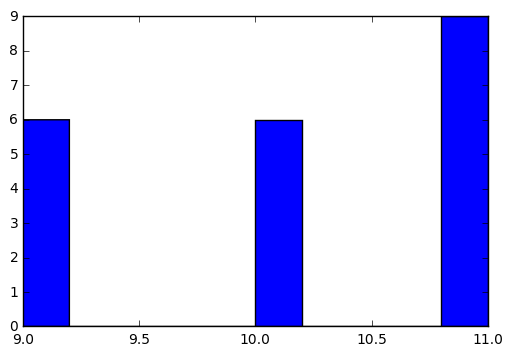

In [16]:
plt.hist(r1)

In [17]:
sum(r1)

213.0

<Container object of 21 artists>

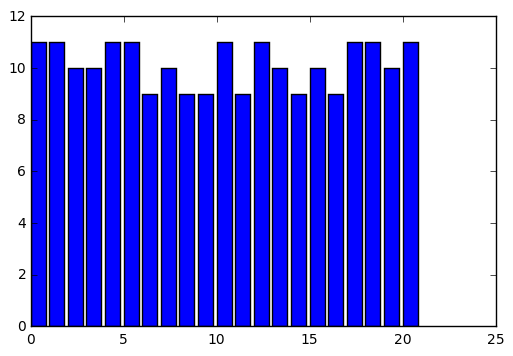

In [22]:
plt.bar(range(21),r1)

In [21]:
score = 0
for i in range(noPapers):
    for j in range(noReferees):
        score += res[i][j] * preferences[i][j]
print score

90.0


In [23]:
import xlwt

In [26]:
workbook = xlwt.Workbook(encoding = 'ascii')
worksheet = workbook.add_sheet('My Worksheet')
for i in range(noPapers):
    for j in range(noReferees):
        if res[i][j] == 1:
            worksheet.write(i, j, res[i][j] * preferences[i][j])
workbook.save('output.xls')